In [ ]:
import os
import cv2
import ast
import gdown
import shutil
import base64
import numpy as np
import pandas as pd
from pathlib import Path
from google.colab import drive
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


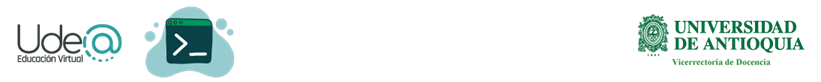

<h1><center>Road Sign Detection

Daniel Felipe Munoz Restrepo

Martin Alirio Barbosa Garzon 

Junio 2023
---

</center></h1>

In [ ]:
drive.mount('/content/drive')

# Ruta de la carpeta en Google Drive que contiene tus imágenes
folder_path = '/content/drive/MyDrive/Senales3/Proyecto Final:Road Sign Detection/dataset/'

# Ruta local donde se guardarán las imágenes descargadas
output_path = '/content/road-sign-detection/'

# Obtener la lista de archivos en la carpeta
file_list = os.listdir(folder_path)

print(file_list)

# Verificar si el directorio de salida ya existe
if not os.path.exists(output_path):
    # Si no existe, copiar el directorio
    shutil.copytree(folder_path, output_path)
    print('Copia completada.')
else:
    print('El directorio de salida ya existe. No se realiza la copia.')

print('Descarga completada.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['annotations', 'images']
El directorio de salida ya existe. No se realiza la copia.
Descarga completada.


In [ ]:
images_path = Path('/content/road-sign-detection/images')
anno_path = Path('/content/road-sign-detection/annotations')

In [ ]:
# Ruta de salida donde se guardarán las imágenes recortadas
output_folder = '/content/road-sign-detection/cropped_images'
target_width = 100  # Ancho objetivo de las imágenes recortadas
target_height = 100  # Alto objetivo de las imágenes recortadas

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Obtener la lista de archivos XML en la carpeta
xml_files = [file for file in os.listdir(anno_path) if file.endswith('.xml')]

for xml_file in xml_files:
    # Ruta del archivo XML
    xml_path = os.path.join(anno_path, xml_file)

    # Parsear el archivo XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Obtener la información de las coordenadas del objeto de interés
    xmin = int(root.find('object/bndbox/xmin').text)
    ymin = int(root.find('object/bndbox/ymin').text)
    xmax = int(root.find('object/bndbox/xmax').text)
    ymax = int(root.find('object/bndbox/ymax').text)

    # Ruta de la imagen asociada al archivo XML
    image_file = root.find('filename').text
    image_path = os.path.join(images_path, image_file)

    # Leer la imagen
    image = cv2.imread(image_path)

    # Recortar la región de interés
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Redimensionar la imagen recortada al tamaño objetivo
    resized_image = cv2.resize(cropped_image, (target_width, target_height))

    # Guardar la imagen recortada y redimensionada
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, resized_image)

# print(os.listdir(output_folder))
print('Recorte y redimensionamiento de imágenes completado.')

Recorte y redimensionamiento de imágenes completado.


Al analizar el dataset, descubrimos que cada imagen está asociada a un archivo XML que proporciona información precisa sobre la ubicación de la señal de tránsito de interés dentro de la imagen. Por lo tanto, el código recorre cada archivo XML en la carpeta de anotaciones. Para cada archivo XML, se lee la imagen correspondiente y se recorta la región de interés definida en el archivo XML. Además, se redimensiona la imagen recortada a un tamaño de 100 x 100 píxeles para asegurar que todas las imágenes tengan las mismas dimensiones. Finalmente, se guarda la imagen recortada en una carpeta de salida. El código utiliza la biblioteca xml.etree.ElementTree para analizar los archivos XML y la biblioteca cv2 para leer, recortar y guardar las imágenes.

In [ ]:
# Ruta del archivo CSV de salida
csv_file = '/content/featureSet.csv'

# Verificar si el archivo CSV ya existe
if os.path.isfile(csv_file):
    # Si el archivo existe, carga el DataFrame existente
    df = pd.read_csv(csv_file)
else:
    # Si el archivo no existe, crea un nuevo DataFrame vacío
    df = pd.DataFrame(columns=['histogram', 'image_file', 'label'])

# Iterar sobre los archivos de imágenes recortadas
for file in os.listdir(output_folder):
  if file.endswith('.png'):
    image_path = os.path.join(output_folder, file)
    image = cv2.imread(image_path)

    if image is not None:
      # Calcular el histograma de color
      hist = cv2.calcHist([image], [0], None, [256], [0, 256])
      hist_normalized = hist.flatten() / hist.sum()

      # Obtener el nombre base del archivo sin la extensión
      file_base = os.path.splitext(file)[0]

      # Ruta del archivo XML correspondiente
      xml_file = os.path.join(anno_path, file_base + '.xml')

      if os.path.isfile(xml_file):
        # Procesar el archivo XML y obtener la etiqueta
        tree = ET.parse(xml_file)
        root = tree.getroot()
        label = root.find('object').find('name').text

        # Crear un nuevo DataFrame con la fila actual
        new_row = pd.DataFrame({'histogram': [hist_normalized.tolist()], 'image_file': [file], 'label': [label]})

        # Concatenar el nuevo DataFrame con el DataFrame existente
        df = pd.concat([df, new_row], ignore_index=True)

        # Guardar el DataFrame en el archivo CSV después de cada cálculo
        df.to_csv(csv_file, index=False)
      else:
        print(f"El archivo XML correspondiente no se encuentra: {xml_file}")
    else:
      print(f"Error al leer la imagen: {file}")

print('Proceso completado.')

Proceso completado.


Ahora procederemos a graficar el histograma de una imagen seleccionada al azar para cada tipo de etiqueta en el dataset. Esto nos permitirá validar si existen diferencias notables en la distribución de colores entre las distintas clases.

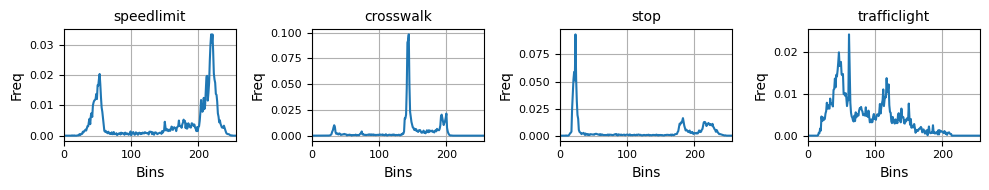

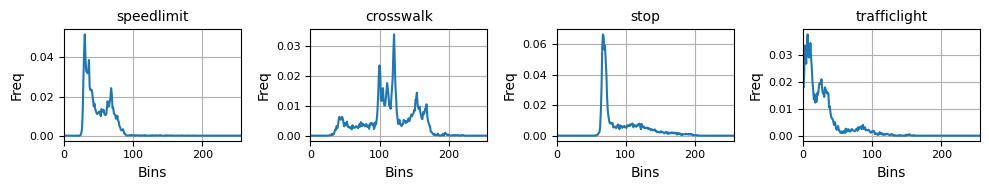

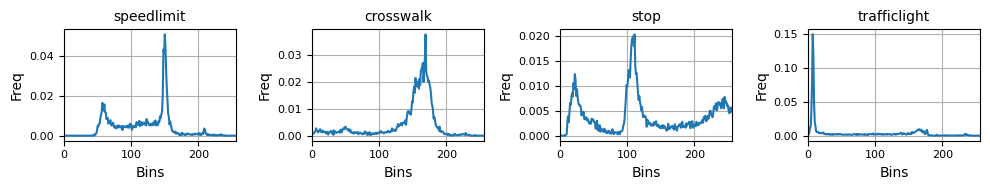

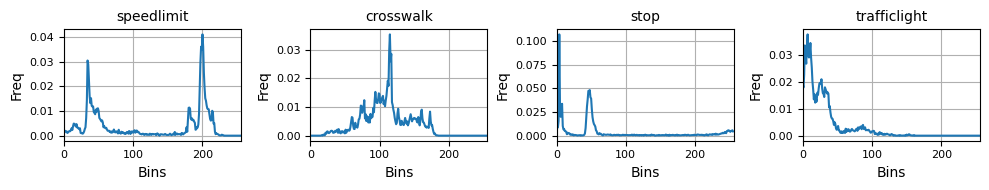

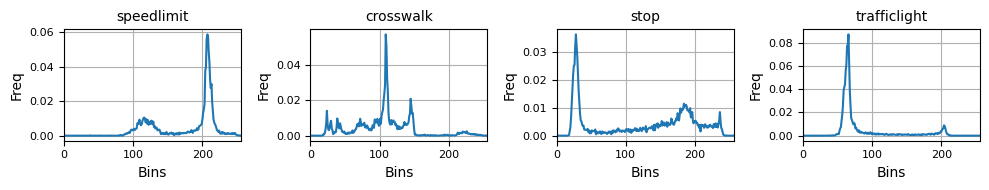

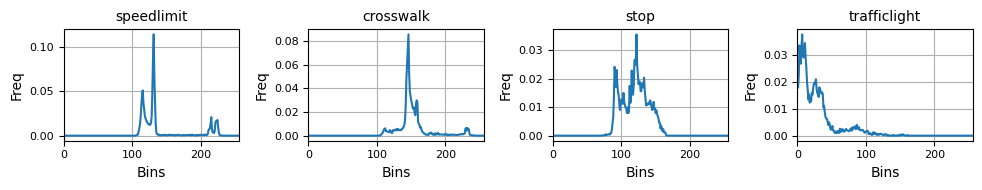

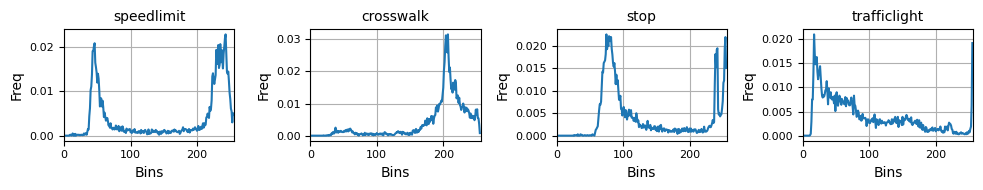

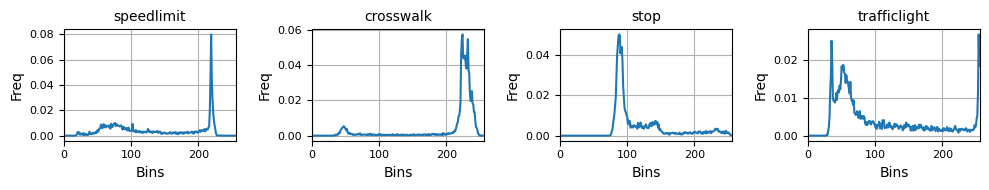

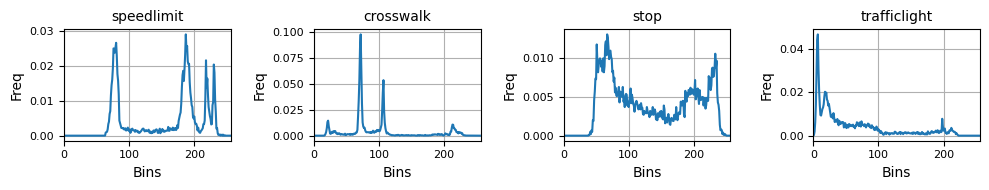

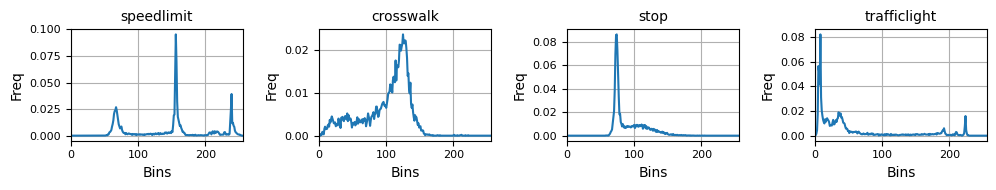

In [ ]:
# Obtener las clases únicas
classes = df['label'].unique()

# Calcular el número de subgráficos por fila
num_subplots = len(classes)

for i in range(10):
  # Configurar el tamaño de la figura y el tamaño de cada subgráfico
  fig, axs = plt.subplots(1, num_subplots, figsize=(10, 2))

  # Iterar sobre las clases
  for i, class_name in enumerate(classes):
      # Filtrar el DataFrame por la clase actual
      class_df = df[df['label'] == class_name]

      # Obtener un índice aleatorio
      random_index = np.random.randint(0, len(class_df))

      # Obtener el histograma y el nombre del archivo aleatorio
      histogram_str = class_df.iloc[random_index]['histogram']
      histogram = ast.literal_eval(histogram_str)
      image_file = class_df.iloc[random_index]['image_file']

      # Generar los valores x para el histograma
      x = np.arange(len(histogram))

      # Graficar el histograma en el subgráfico correspondiente
      axs[i].plot(x, histogram)

      # Configurar los límites del eje x
      axs[i].set_xlim([0, len(histogram)])

      # Reducir el tamaño de la fuente del título
      axs[i].set_title(f'{class_name}', fontsize=10)
      axs[i].set_xlabel('Bins')
      axs[i].set_ylabel('Freq')

      # Graficamos la cuadrícula con un espaciado más denso
      axs[i].grid()

      # Reducir el tamaño de la fuente de los labels de los ejes
      axs[i].tick_params(axis='both', labelsize=8)

  # Ajustar el espaciado entre subgráficos
  plt.tight_layout()

  # Mostrar la figura
  plt.show()


En los diferentes histogramas se pueden apreciar ciertos patrones en cada grupo. Por ejemplo, en los semáforos se observa que hay una concentración de muchos píxeles en tonalidades cercanas al negro. Esto es de esperar, ya que en estos elementos tenemos la cobertura total de las luces predominando, y luego solo alguna de las tres luces encendidas.

Para las señales de límite de velocidad, se puede observar comúnmente la presencia de 2 picos de intensidad en el histograma. Estos patrones característicos pueden deberse a la presencia de elementos distintivos en las señales, como números o símbolos de límites de velocidad.

Cada grupo en el dataset tiene sus propios patrones característicos en los histogramas, lo que refleja las diferencias en la distribución de colores y la intensidad en cada tipo de señal de tráfico. Estos patrones pueden ser útiles para la detección y clasificación automática de las señales de tráfico en futuros modelos y algoritmos.

Calcular el histograma de una imagen es un paso importante en el proceso de detección de señales de tráfico utilizando el dataset de Road Sign Detection de Kaggle. El histograma de una imagen representa la distribución de los valores de los píxeles en la imagen. Proporciona información sobre la intensidad y la frecuencia de aparición de diferentes niveles de gris o colores en la imagen.

Aquí hay algunas razones por las que el cálculo del histograma es útil para el ejercicio de detección de señales de tráfico:

**Características distintivas**: Las señales de tráfico suelen tener características visuales específicas, como formas, colores y patrones. El histograma puede capturar estas características distintivas mediante la representación de la distribución de los valores de píxeles relacionados con esas características. Esto permite identificar patrones de intensidad o color que son típicos de las señales de tráfico.

**Normalización de iluminación**: Las condiciones de iluminación pueden variar en las imágenes de señales de tráfico. El cálculo del histograma permite normalizar la iluminación, lo que implica igualar la distribución de los niveles de gris o colores en la imagen. Esto ayuda a reducir la variabilidad causada por diferentes condiciones de iluminación y facilita la detección de características relevantes.

**Comparación y clasificación**: El histograma proporciona una representación compacta de las características visuales de una imagen. Al calcular el histograma de las imágenes de señales de tráfico en el dataset, se obtiene una representación numérica de cada imagen. Esto facilita la comparación y clasificación de las imágenes utilizando técnicas de análisis de patrones y aprendizaje automático. Puedes medir la similitud o la diferencia entre los histogramas de diferentes imágenes para determinar si pertenecen a la misma clase o no.

**Eficiencia computacional**: El histograma es una representación reducida de la información visual de una imagen. En lugar de trabajar con la imagen completa, puedes trabajar con su histograma, lo que puede ser computacionalmente más eficiente. Esto es especialmente beneficioso cuando se manejan grandes volúmenes de datos, como en el caso de un dataset de detección de señales de tráfico con muchas imágenes.

Color: Puedes extraer información de color de las imágenes, como histogramas de color, valores de intensidad promedio o características cromáticas específicas para detectar patrones relacionados con las señales de tránsito.

Forma: Puedes utilizar algoritmos de detección de contornos para identificar formas y estructuras relevantes en las imágenes. Por ejemplo, puedes buscar formas circulares, triangulares, octogonales, etc., que sean características de ciertos tipos de señales de tránsito.

Textura: Puedes analizar la textura de las imágenes para buscar patrones de textura característicos de las señales de tránsito. Esto puede incluir características como bordes, gradientes, patrones repetitivos, etc.

Características geométricas: Puedes extraer características geométricas, como la relación de aspecto, el área, la ubicación y la orientación de las señales de tránsito dentro de la imagen.

Descriptores de puntos clave: Puedes utilizar algoritmos de detección de puntos clave, como SIFT, SURF o ORB, para identificar puntos clave en las imágenes y describir sus características locales. Estos descriptores pueden ayudar a identificar las características distintivas de las señales de tránsito.

Redes neuronales convolucionales (CNN): Puedes utilizar arquitecturas de CNN pre-entrenadas, como VGG, ResNet o Inception, y extraer características de alto nivel de las capas convolucionales para alimentarlas al modelo. Estas características aprendidas pueden capturar información importante en las imágenes relacionada con las señales de tránsito.

1. Support Vector Machines (SVM): SVM es un algoritmo que se utiliza comúnmente para problemas de clasificación. Su objetivo principal es encontrar un hiperplano en un espacio dimensional superior que pueda separar de manera óptima las diferentes clases de datos. En el contexto de reconocimiento de señales de tráfico, SVM puede ser efectivo para clasificar las diferentes señales en categorías específicas.

2. Random Forest: Random Forest es un algoritmo de aprendizaje en conjunto que combina múltiples árboles de decisión para realizar la clasificación. Cada árbol en el bosque se entrena con una muestra aleatoria de datos y produce una clasificación. Luego, el resultado final se determina por votación o promediando las predicciones de los árboles individuales. Random Forest es conocido por su eficacia y su capacidad para manejar características de alta dimensionalidad, lo que puede ser útil en el reconocimiento de señales de tráfico donde las características pueden ser diversas.

In [67]:
!zip -r "/content/cropped_images.zip" "/content/road-sign-detection/cropped_images"

  adding: content/road-sign-detection/cropped_images/ (stored 0%)
  adding: content/road-sign-detection/cropped_images/road428.png (deflated 0%)
  adding: content/road-sign-detection/cropped_images/road307.png (deflated 1%)
  adding: content/road-sign-detection/cropped_images/road316.png (deflated 1%)
  adding: content/road-sign-detection/cropped_images/road303.png (deflated 1%)
  adding: content/road-sign-detection/cropped_images/road333.png (deflated 2%)
  adding: content/road-sign-detection/cropped_images/road191.png (deflated 2%)
  adding: content/road-sign-detection/cropped_images/road647.png (deflated 6%)
  adding: content/road-sign-detection/cropped_images/road54.png (deflated 0%)
  adding: content/road-sign-detection/cropped_images/road178.png (deflated 2%)
  adding: content/road-sign-detection/cropped_images/road390.png (deflated 1%)
  adding: content/road-sign-detection/cropped_images/road276.png (deflated 5%)
  adding: content/road-sign-detection/cropped_images/road317.png (